In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

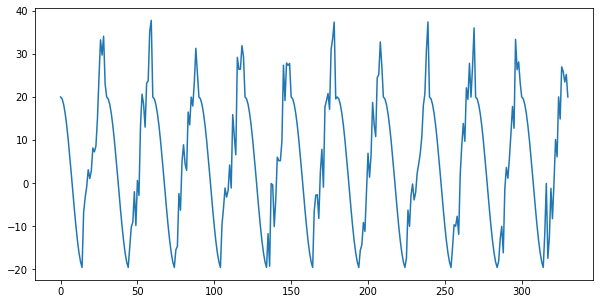

In [ ]:
np.random.seed(12345)
tf.random.set_seed(12345)

x = np.arange(30 * 12 + 1)
month_time = (x % 30) / 30
y = 20 * np.where(month_time < 0.5, 
                          np.cos(2 * np.pi * month_time),
                          np.cos(2 * np.pi * month_time) + np.random.random(361))


plt.figure(figsize = (10, 5)) 
plt.plot(np.arange(0, 30 * 11 + 1), y[:30 * 11 + 1])

In [ ]:
# LSTM, GRU 을 이용해서 model 을 학습시키고 https://www.tensorflow.org/guide/keras/rnn?hl=ko 
# x 축을 360 이후로 Data를 예측해보세요.
# RNN model을 다중으로 구성하기 위해서는 return_sequences = True 를 활성화 해줘야 합니다. 

In [ ]:
df = pd.DataFrame(data=y, index=x, columns=["time_cos"])

In [ ]:
train_set = y

In [ ]:
y.shape

(361,)

In [ ]:
# 0~1 값으로 줄여준다 -> loss 값이 너무 크게 나오지 않게 하기위해서
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)

s_train = scaler.transform(df)

In [ ]:
s_train.shape

(361, 1)

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 30 # month_time을 30으로 나눠줘서
generator = TimeseriesGenerator(s_train, s_train, length=length, batch_size=1)

In [ ]:
generator[0][0].shape

(1, 30, 1)

In [ ]:
# lstm 
model_lstm = tf.keras.models.Sequential(name="model_lstm")
model_lstm.add(tf.keras.layers.LSTM(30, input_shape=(30,1)))
model_lstm.add(tf.keras.layers.Dense(1))


model_lstm.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
# lstm + sigmoid (activation function 을 다른걸 사용 )
# Relu
model_lstm_sig = tf.keras.models.Sequential(name="model_lstm_sig")
model_lstm_sig.add(tf.keras.layers.LSTM(30, activation = "sigmoid", input_shape=(30,1)))
model_lstm_sig.add(tf.keras.layers.Dense(1))

model_lstm_sig.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
# gru 생성
model_gru = tf.keras.models.Sequential(name="model_gru")
model_gru.add(tf.keras.layers.GRU(30, input_shape=(30,1)))
model_gru.add(tf.keras.layers.Dense(1))

model_gru.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
# lstm -> sequence data -> gru 
# RNN model 을 동시에 쌓기 위해서는 return_sequences = True 
model_lstm_gru = tf.keras.models.Sequential(name="model_lstm_gru")
model_lstm_gru.add(tf.keras.layers.LSTM(30, return_sequences=True, input_shape=(30,1)))
model_lstm_gru.add(tf.keras.layers.GRU(30))
model_lstm_gru.add(tf.keras.layers.Dense(1))

model_lstm_gru.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
# model 학습 
model_list = [model_lstm_sig, model_lstm, model_gru, model_lstm_gru]
for i in model_list:
  i.fit(generator, epochs = 5)

Epoch 1/5
331/331 [==============================] - 22s 56ms/step - loss: 0.0629
Epoch 2/5
331/331 [==============================] - 16s 47ms/step - loss: 0.0413
Epoch 3/5
331/331 [==============================] - 14s 43ms/step - loss: 0.0266
Epoch 4/5
331/331 [==============================] - 14s 42ms/step - loss: 0.0197
Epoch 5/5
331/331 [==============================] - 14s 43ms/step - loss: 0.0162
Epoch 1/5
331/331 [==============================] - 6s 4ms/step - loss: 0.0339
Epoch 2/5
331/331 [==============================] - 1s 4ms/step - loss: 0.0075
Epoch 3/5
331/331 [==============================] - 1s 4ms/step - loss: 0.0072
Epoch 4/5
331/331 [==============================] - 1s 4ms/step - loss: 0.0071
Epoch 5/5
331/331 [==============================] - 1s 4ms/step - loss: 0.0074
Epoch 1/5
331/331 [==============================] - 3s 4ms/step - loss: 0.0427
Epoch 2/5
331/331 [==============================] - 1s 4ms/step - loss: 0.0088
Epoch 3/5
331/331 [===========

In [ ]:
df

,time_cos
0,20.000000
1,19.562952
2,18.270909
3,16.180340
4,13.382612
...,...
356,26.613717
357,18.876043
358,34.027889
359,22.322506


In [ ]:
df_2 = df.drop(df.index[0:length]) #0~29 까지의 데이터는 30을 예측하는데 사용 따라서 예측한 값과 원래 데이터의 index를 맞추기 위해서 drop
for i in model_list: #학습된 model 을 이용해 predict (30~360 까지의 데이터)
  tmp = i.predict(generator)
  tmp_2 = scaler.inverse_transform(tmp) #minmax scaler 를 통해 변경된 값으로 model이 예측하기 때문에 inverse_transform으로 되돌려준다. 
  df_2[i.name] = tmp_2

331/331 [==============================] - 1s 3ms/step


In [ ]:
df_2

,time_cos,model_lstm_sig,model_lstm,model_gru,model_lstm_gru
30,20.000000,20.952322,25.498980,24.278158,21.198284
31,19.562952,18.180941,22.292263,19.610817,17.624908
32,18.270909,17.343153,18.865986,16.320881,13.935555
33,16.180340,16.277929,15.268559,13.533704,10.373472
34,13.382612,14.688067,11.557024,10.796131,6.996206
...,...,...,...,...,...
356,26.613717,14.486959,24.334606,20.849188,21.734039
357,18.876043,19.880505,27.179268,24.436111,23.416660
358,34.027889,16.408604,26.938057,22.455532,22.391613
359,22.322506,25.234636,28.811771,27.066803,23.335205


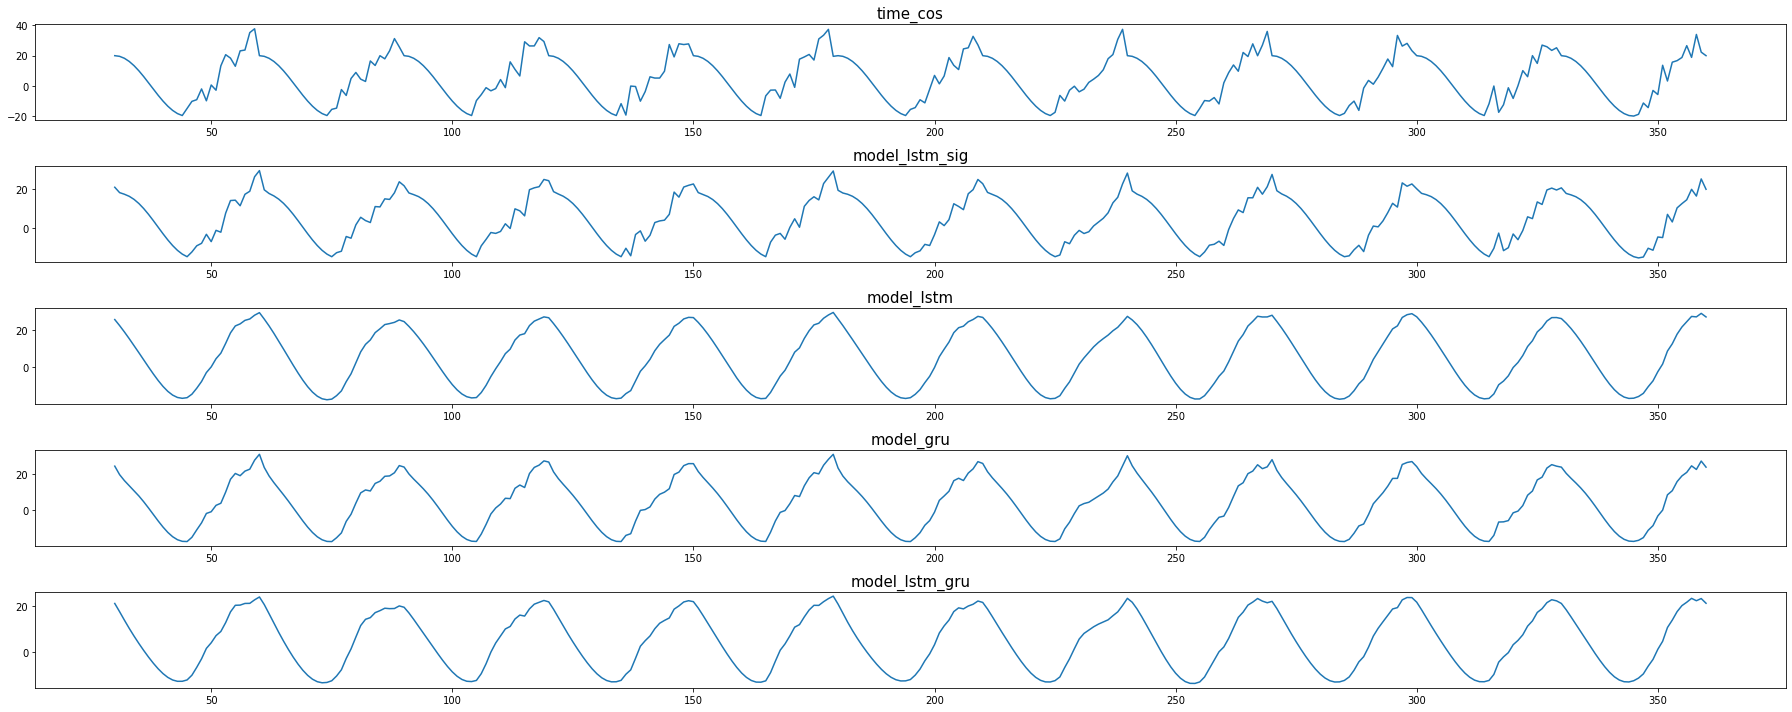

In [ ]:
plt.figure(figsize=(25,10))
n=1
for i in df_2.columns:
    ax = plt.subplot(len(df_2.columns),1,n)
    plt.title(f"{i}", fontsize=15)
    ax.plot(df_2.index, df_2[i], label=str(i))
    n+=1
plt.tight_layout()

1/1 [==============================] - 0s 19ms/step


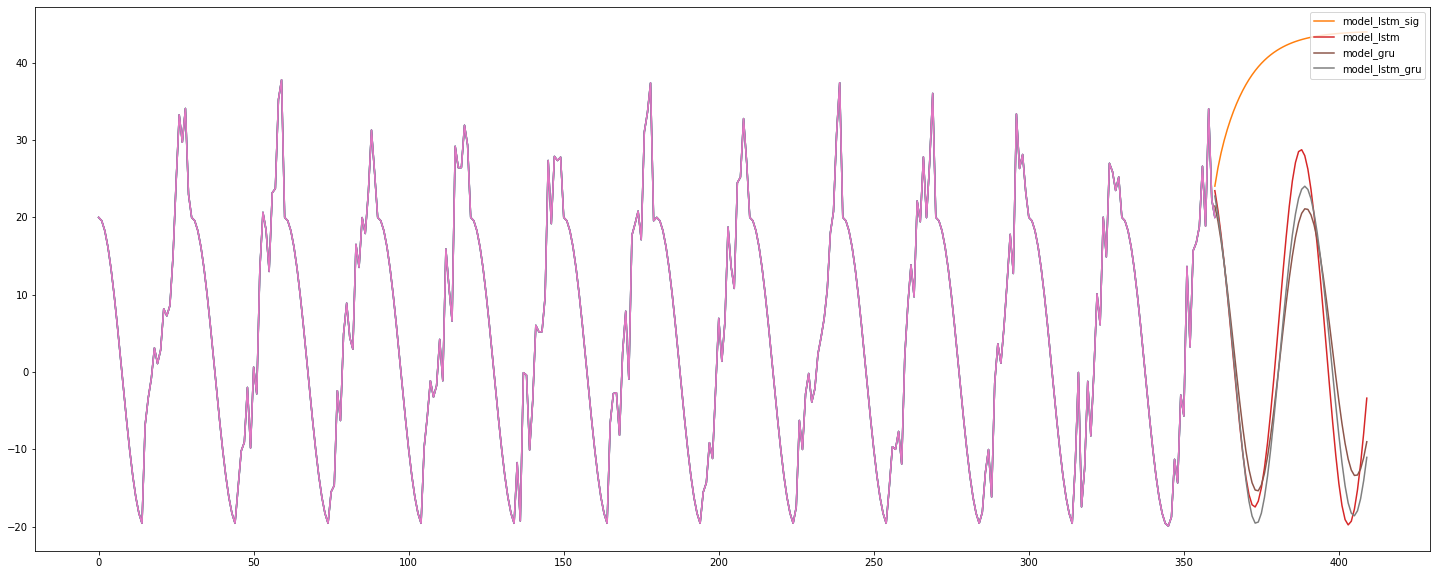

In [ ]:
# predict
plt.figure(figsize=(25,10))

for i in model_list:
  forecast = [] #예측한 값들을 집어넣는 list
  batch = s_train[-30:] # 361 부터 예측하기 위해 사용할 값 [330~359]
  current_batch = batch.reshape((1, 30, 1)) # minmax -> timeseriesgenerator -> 1,30,1
  forecast_index = np.arange(360, 410, step=1) # 예측한 값의 index
  for j in range(50):
    current_pred = i.predict(current_batch)[0] # 예측한값
    forecast.append(current_pred) # 예측한값 추가
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) #current_batch 재할당 : 맨앞의 데이터를 삭제 + 맨뒤에 예측한 데이터를 추가 
  forecast = scaler.inverse_transform(forecast) #minmax scaler 를 이용해 원래 scale 로 돌려줌 
  
  plt.plot(df.index, df['time_cos'])
  plt.plot(forecast_index, forecast, label=f"{i.name}")
  plt.legend(loc='upper right')